In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
import sys
sys.path.append('/content/drive/My Drive/CS7643_GroupProject')

In [188]:
import pandas as pd
import numpy as np
import csv
import random
from PIL import Image
from collections import defaultdict
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt

#from model.deep_emotion import Deep_Emotion
#from model.customCNN import CustomCNN

%matplotlib inline

#Exploration of the fer2013 dataset.
Code modified from https://www.kaggle.com/code/vaibhavgovindwar/fer-cnn-lenet-5, https://www.kaggle.com/code/vkoriukina/fer2018-emotion-recognition-pytorch-resnet-18

In [144]:
df = pd.read_csv('/content/drive/My Drive/CS7643_GroupProject/data/fer2013.csv')

In [145]:
df.shape

(35887, 3)

In [146]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [147]:
df.Usage.value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


In [167]:
emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=True).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_labels)
emotion_counts

,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Disgust,547


#Visualize the distribution of the dataset

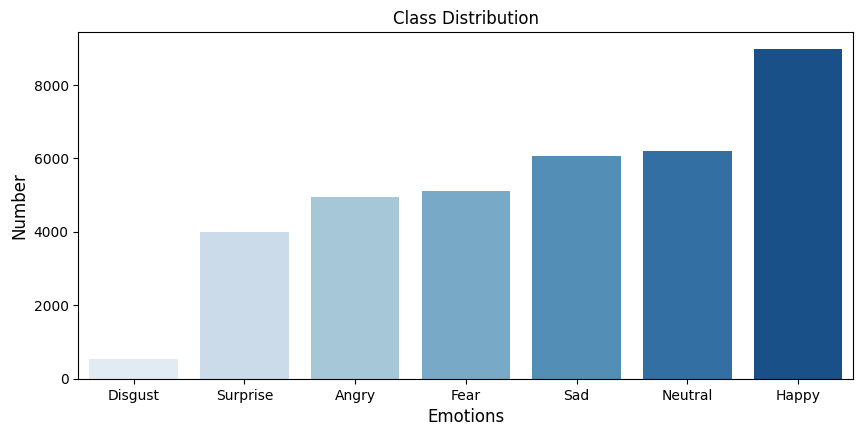

In [168]:
emotion_counts_sorted = emotion_counts.sort_values(by='number', ascending=True)
colors = sns.color_palette("Blues", len(emotion_counts_sorted))

plt.figure(figsize=(10, 4.5))
sns.barplot(x=emotion_counts_sorted.emotion, y=emotion_counts_sorted.number, hue=emotion_counts_sorted.emotion, palette=colors)
plt.title('Class Distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

#Visualize the emotions

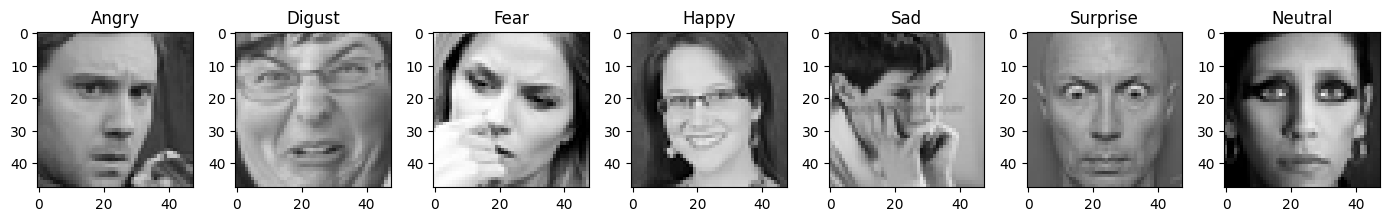

In [13]:
def row2image(row):
    pixels = row['pixels']
    emotion = emotion_labels[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8)
    img = img.reshape(48, 48)
    # Repeat the single-channel image to create a three-channel image
    image = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return image, emotion

plt.figure(figsize=(14,9))
for i in range(1, 8):
    face = df[df['emotion'] == i-1].iloc[0]
    img, emotion = row2image(face)
    plt.subplot(1, 7, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
plt.tight_layout()
plt.show()

# Seperate Train, Validation, Test Data

In [169]:
train_df = df[df['Usage']=='Training']
val_df   = df[df['Usage']=='PublicTest']
test_df  = df[df['Usage']=='PrivateTest']
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(train_df.shape, val_df.shape, test_df.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


# Visualize the training dataset

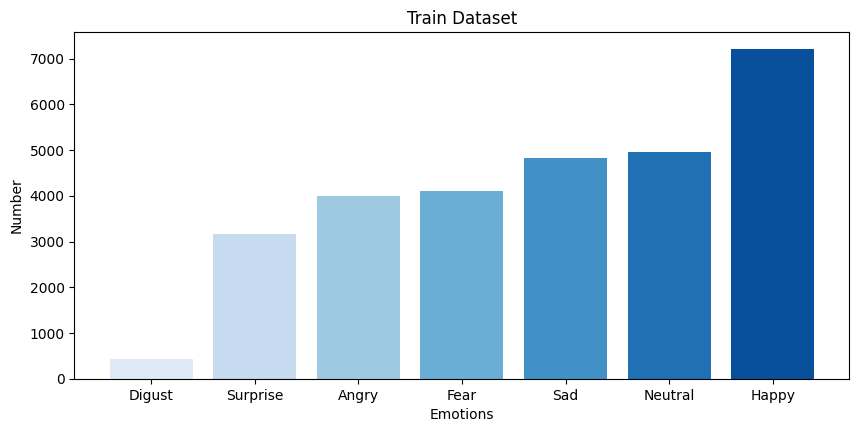

In [15]:
train_emotion_counts_sorted = train_df['emotion'].value_counts().sort_values(ascending=True)
colors = sns.color_palette("Blues", n_colors=len(train_emotion_counts_sorted))

plt.figure(figsize=(10, 4.5))
plt.bar(range(len(train_emotion_counts_sorted)), train_emotion_counts_sorted.values, color=colors)
plt.xticks(range(len(train_emotion_counts_sorted)), [emotion_labels[i] for i in train_emotion_counts_sorted.index])
plt.title('Train Dataset')
plt.ylabel('Number')
plt.xlabel('Emotions')
plt.show()

# Visualize the validation dataset

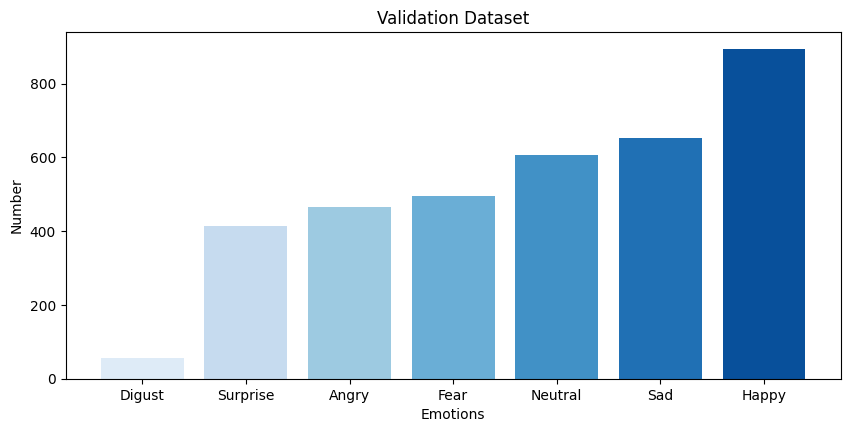

In [16]:
val_emotion_counts_sorted = val_df['emotion'].value_counts().sort_values(ascending=True)

# Define a gradient of colors from light blue to blue
colors = sns.color_palette("Blues", n_colors=len(val_emotion_counts_sorted))

# Plot the bar plot for validation data
plt.figure(figsize=(10, 4.5))
plt.bar(range(len(val_emotion_counts_sorted)), val_emotion_counts_sorted.values, color=colors)
plt.xticks(range(len(val_emotion_counts_sorted)), [emotion_labels[i] for i in val_emotion_counts_sorted.index])
plt.title('Validation Dataset')
plt.ylabel('Number')
plt.xlabel('Emotions')
plt.show()

# Visualize the test dataset

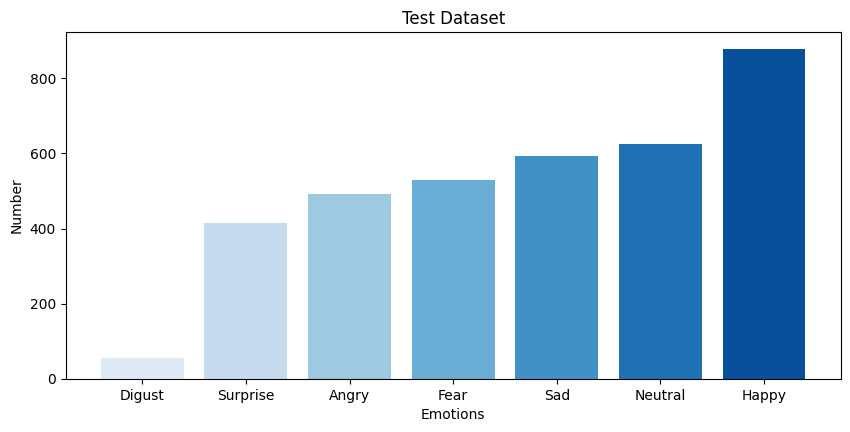

In [17]:
test_emotion_counts_sorted = test_df['emotion'].value_counts().sort_values(ascending=True)
colors = sns.color_palette("Blues", n_colors=len(test_emotion_counts_sorted))

plt.figure(figsize=(10, 4.5))
plt.bar(range(len(test_emotion_counts_sorted)), test_emotion_counts_sorted.values, color=colors)
plt.xticks(range(len(test_emotion_counts_sorted)), [emotion_labels[i] for i in test_emotion_counts_sorted.index])
plt.title('Test Dataset')
plt.ylabel('Number')
plt.xlabel('Emotions')
plt.show()

# Create a custom dataset class
Convert pixel strings from csv file to image and label in tensor form

In [170]:
class FER2013Dataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (DataFrame): The dataset loaded using pandas DataFrame.
            transform (callable, optional): Optional transformations to apply to the images.
        """
        self.data = data
        self.transform = transform
        self.labels = data['emotion'].values
        self.pixels = data['pixels'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the pixel string to a numpy array and reshape to 48x48
        image = (np.array(self.pixels[idx].split(), dtype=np.float32)/255).reshape(48, 48)
        label = int(self.labels[idx])  # Get the label as an integer

        # Apply transformations if provided
        if self.transform:
            image = Image.fromarray((image * 255).astype(np.uint8))
            image = self.transform(image)

        # Convert image and label to tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

#Define Transformation and Initialize Datasets

In [171]:
train_transform = transforms.Compose([
    transforms.ToTensor(), # Normalize pixel values from [0, 255] to [0, 1]
    transforms.Normalize([0.5], [0.5]) # Normalize pixel values to [-1, 1]
])

# Data augmentation of horizontal mirroring, ±10 degree rotations, ±10% image zooms, and ±10% horizontal/vertical shifting
train_transform_with_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1), # ±10% horizontal and vertical shifting
        scale=(0.9, 1.1) # ±10% zoom (scale between 90% and 110%)
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = FER2013Dataset(train_df, train_transform)
train_dataset_with_augmentation = FER2013Dataset(train_df, train_transform_with_augmentation)
val_dataset = FER2013Dataset(val_df, test_transform)
test_dataset = FER2013Dataset(test_df, test_transform)

# Create DataLoader

In [172]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
train_augmented_dataloader = DataLoader(train_dataset_with_augmentation, BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE)

# Visualize a Single Normalized Image

<ipython-input-75-492a39c40806>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


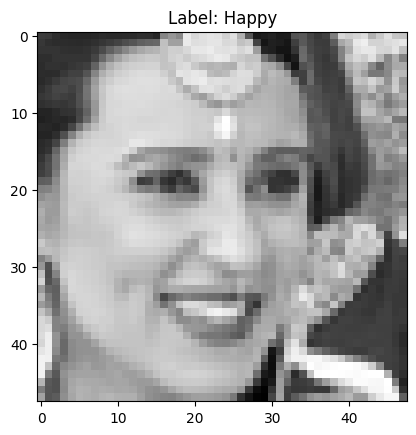

In [88]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
i = random.randint(0, images.size(0) - 1)
plt.imshow(images[i][0].numpy(), cmap='gray')
plt.title(f"Label: {emotion_labels[labels[i].item()]}")
plt.show()

# Visualize a batch of normalized train data without augmentation

<ipython-input-117-492a39c40806>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


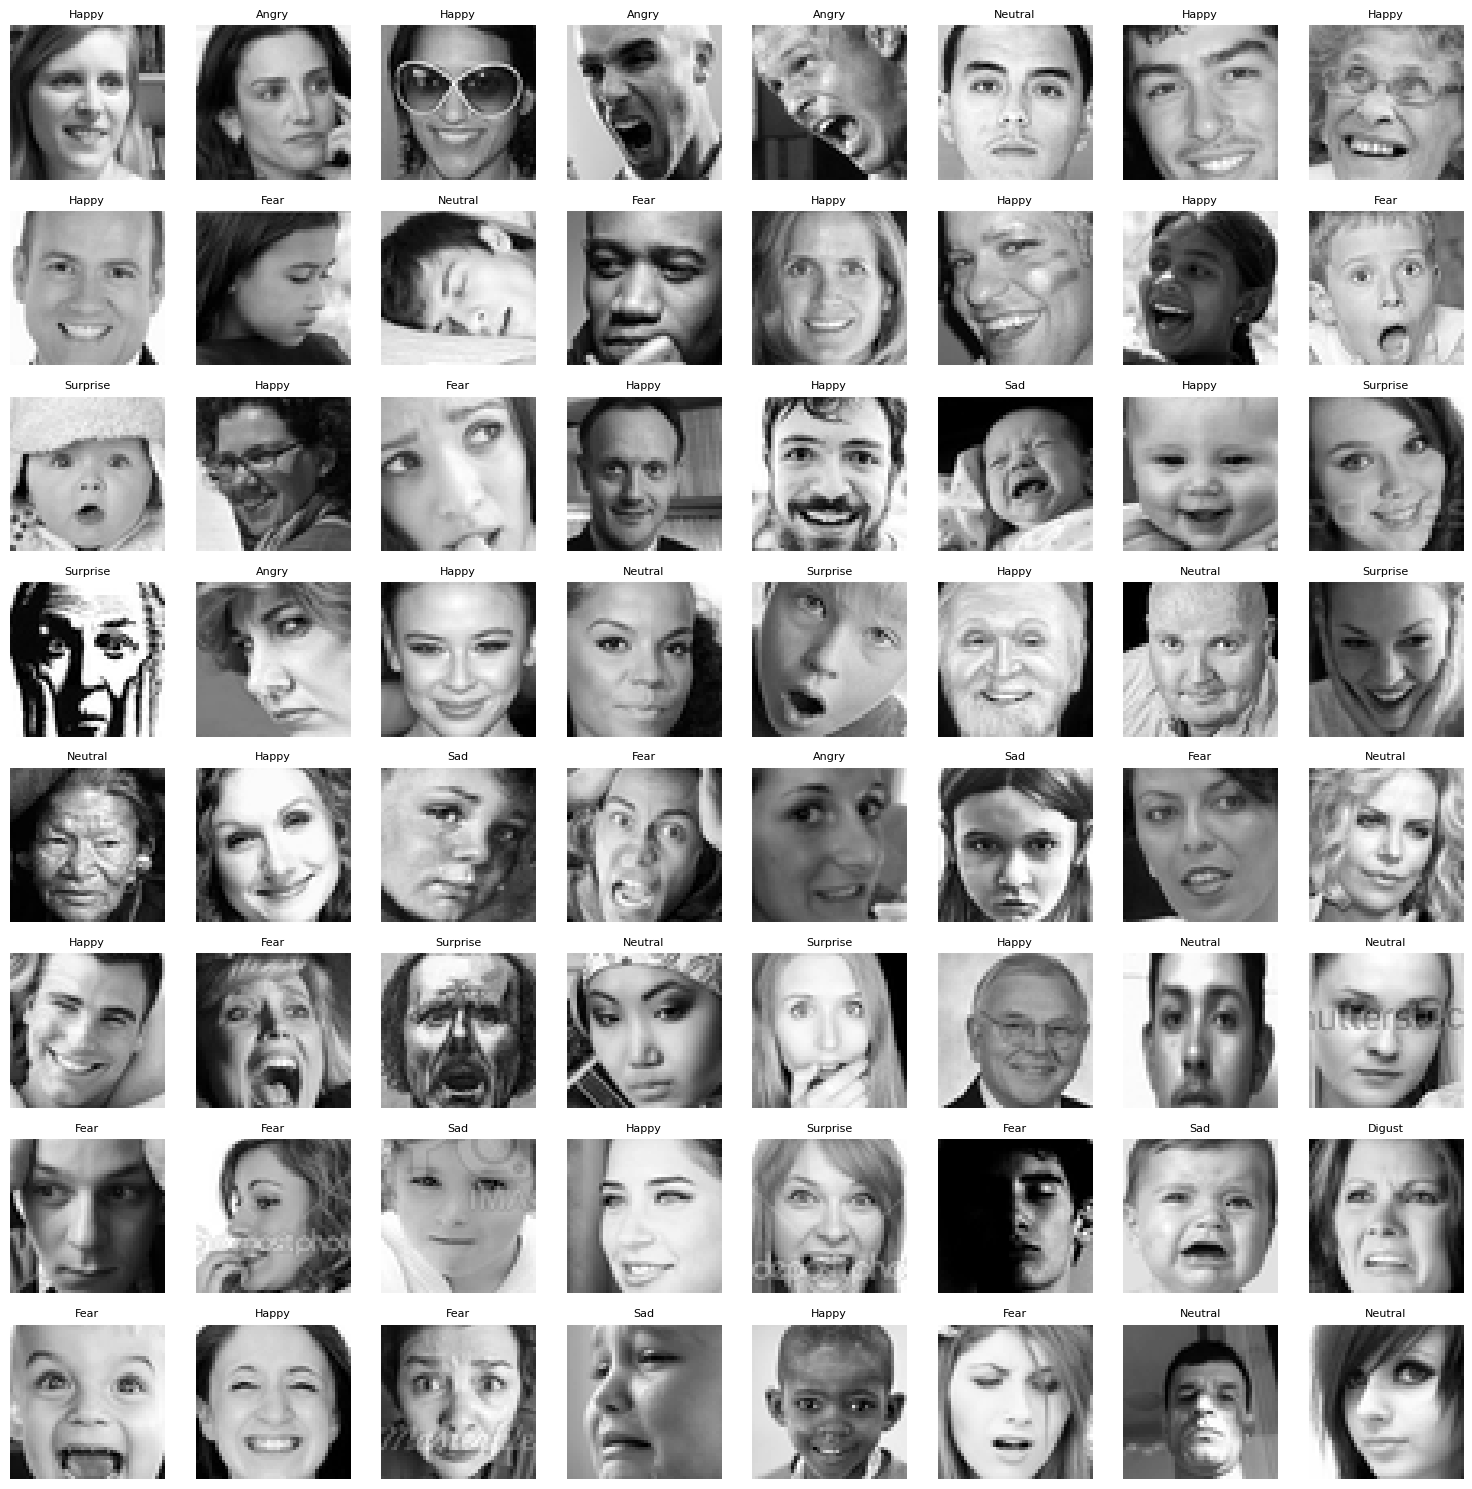

In [122]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))
for idx in range(64):
    row, col = divmod(idx, 8)  # Compute row and column index
    img = images[idx][0].numpy() # Get the image (convert to numpy for display)
    label = emotion_labels[labels[idx].item()]  # Get the corresponding label

    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(f"{label}", fontsize=8)  # Smaller font for clarity
    axes[row, col].axis('off')  # Turn off the axes

plt.tight_layout()
plt.show()

# Visualize a batch of normalized and augmented train data


<ipython-input-117-492a39c40806>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


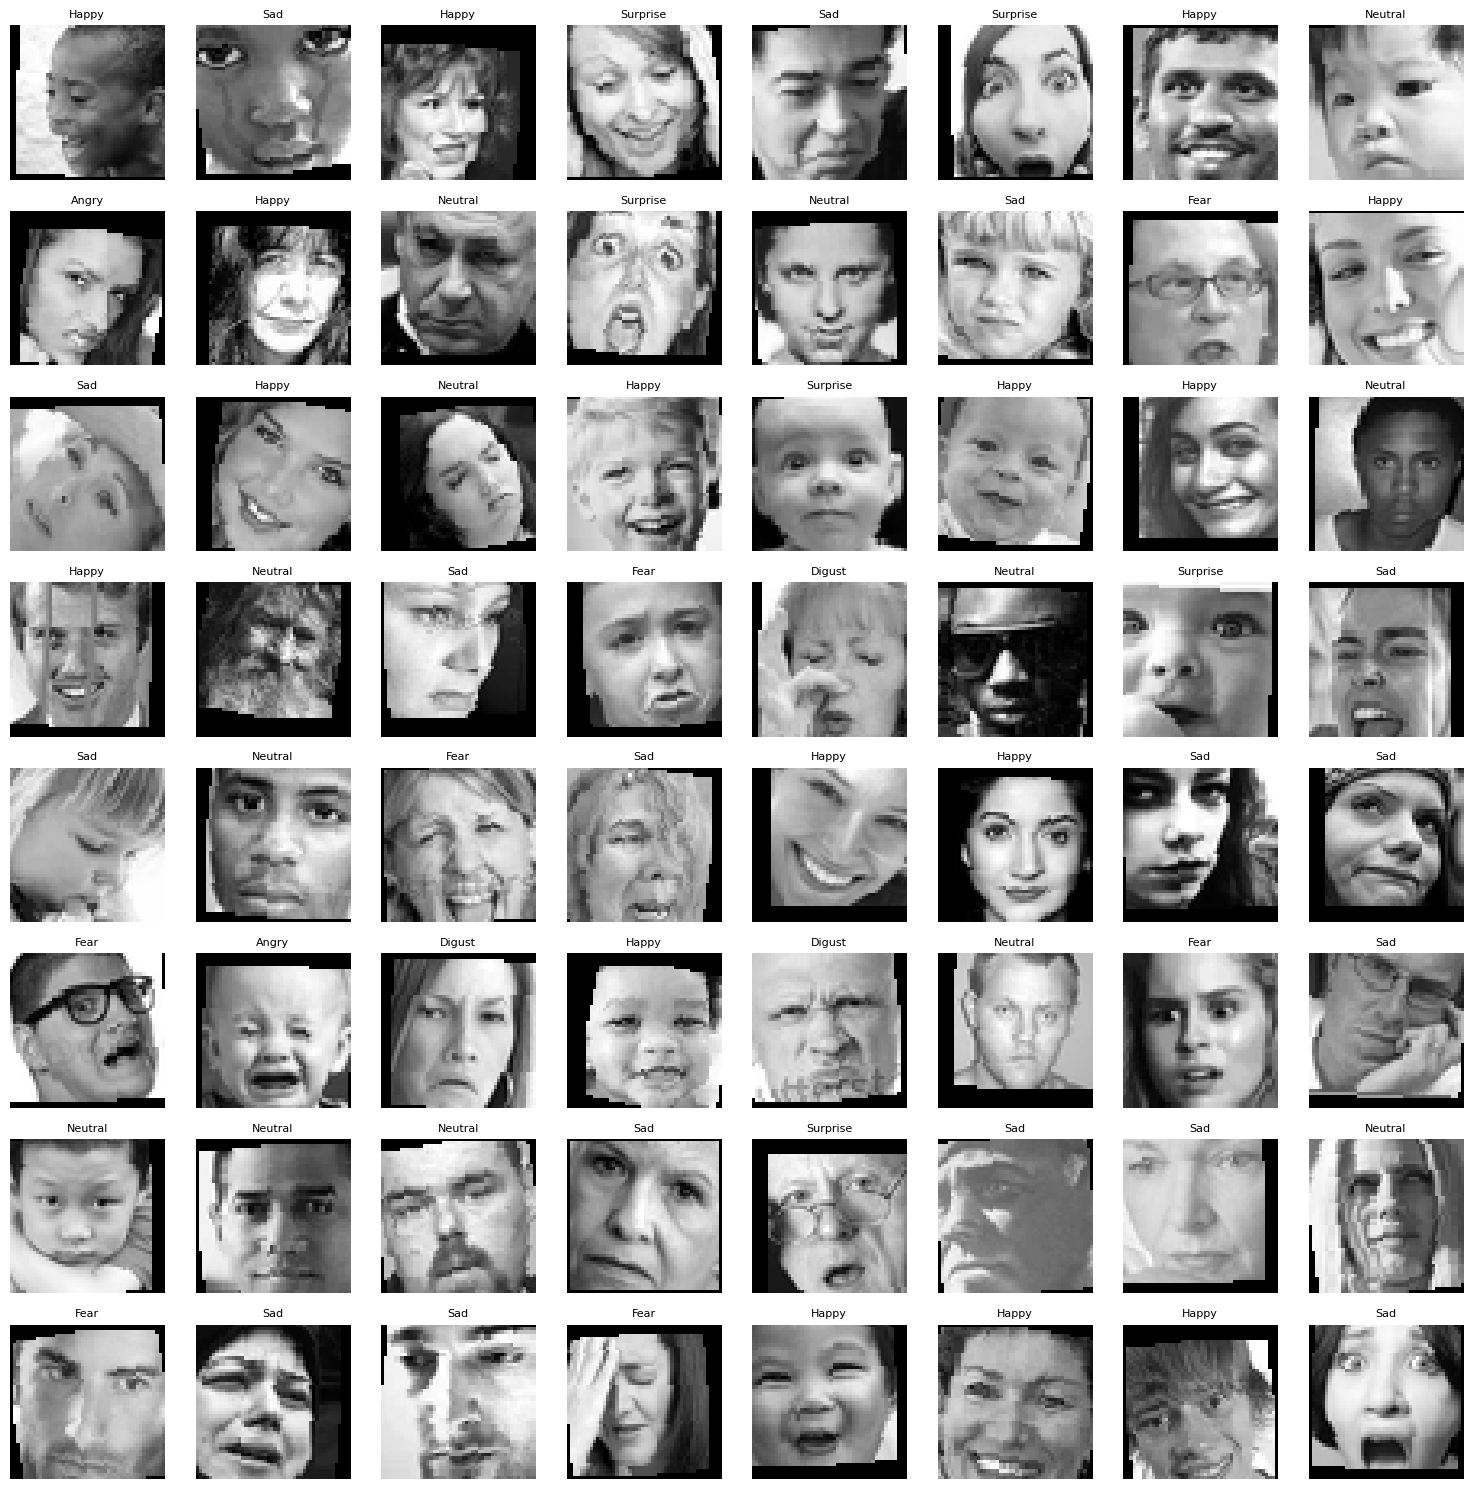

In [124]:
dataiter = iter(train_augmented_dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))
for idx in range(64):
    row, col = divmod(idx, 8)  # Compute row and column index
    img = images[idx][0].numpy()  # Get the image (convert to numpy for display)
    label = emotion_labels[labels[idx].item()]  # Get the corresponding label

    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(f"{label}", fontsize=8)  # Smaller font for clarity
    axes[row, col].axis('off')  # Turn off the axes

plt.tight_layout()
plt.show()


In [128]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Model = ResNet18 (pretrained)

In [173]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(512, 7)
model = model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Define Optimizer, Loss Function and Hyperparameters

In [179]:
EPOCHS = 20
LEARNING_RATE = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=5e-2, lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Define Train, Validation and Accuracy Function

In [180]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    train_running_loss = 0.0
    train_running_acc = 0.0

    for images, labels in tqdm(dataloader, desc="Training...", total=len(dataloader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        train_running_loss += loss.clone().detach()
        train_running_acc += accuracy(outputs.clone().detach(), labels)

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / len(dataloader)
    train_acc = train_running_acc / len(dataloader)

    return train_loss, train_acc

In [181]:
def validate(model, dataloader, optimizer, loss_fn):
    model.eval()

    valid_running_loss = 0.0
    vaild_running_acc = 0.0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating...", total=len(dataloader)):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.clone().detach()
            vaild_running_acc += accuracy(outputs.clone().detach(), labels)

    valid_loss = valid_running_loss / len(dataloader)
    valid_acc = vaild_running_acc / len(dataloader)

    return valid_loss, valid_acc

In [182]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Train using augmented data

In [183]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(1, EPOCHS + 1):
    train_epoch_loss, train_epoch_acc = train(model, train_augmented_dataloader, optimizer, loss_function)
    val_epoch_loss, val_epoch_acc = validate(model, val_dataloader, optimizer, loss_function)
    scheduler.step(val_epoch_loss)

    train_loss.append(train_epoch_loss.detach().cpu().numpy())
    val_loss.append(val_epoch_loss.detach().cpu().numpy())
    train_acc.append(train_epoch_acc.detach().cpu().numpy())
    val_acc.append(val_epoch_acc.detach().cpu().numpy())
    print(f'Epoch: {epoch},\
          Train loss: {train_epoch_loss:.4f},\
          Train acc: {train_epoch_acc:.4f},\
          Val loss: {val_epoch_loss:.4f},\
          Val acc: {val_epoch_acc:.4f}\
          ')
print('DONE TRAINING')

Training...:   0%|          | 0/449 [00:00<?, ?it/s]

<ipython-input-170-492a39c40806>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 1,          Train loss: 1.0447,          Train acc: 0.6102,          Val loss: 1.0760,          Val acc: 0.6008          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 2,          Train loss: 0.9971,          Train acc: 0.6278,          Val loss: 1.0219,          Val acc: 0.6152          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 3,          Train loss: 1.0359,          Train acc: 0.6117,          Val loss: 1.0545,          Val acc: 0.6087          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 4,          Train loss: 0.9842,          Train acc: 0.6295,          Val loss: 1.0741,          Val acc: 0.6081          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 5,          Train loss: 0.9914,          Train acc: 0.6264,          Val loss: 1.0714,          Val acc: 0.6098          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 6,          Train loss: 0.9921,          Train acc: 0.6249,          Val loss: 1.0643,          Val acc: 0.6152          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 7,          Train loss: 0.9778,          Train acc: 0.6320,          Val loss: 1.0855,          Val acc: 0.6120          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 8,          Train loss: 0.9612,          Train acc: 0.6389,          Val loss: 1.0526,          Val acc: 0.6221          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 9,          Train loss: 0.9532,          Train acc: 0.6433,          Val loss: 1.0970,          Val acc: 0.6084          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 10,          Train loss: 0.9458,          Train acc: 0.6451,          Val loss: 1.0709,          Val acc: 0.6082          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 11,          Train loss: 0.9458,          Train acc: 0.6442,          Val loss: 1.0977,          Val acc: 0.6136          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 12,          Train loss: 0.9381,          Train acc: 0.6482,          Val loss: 1.0284,          Val acc: 0.6311          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 13,          Train loss: 0.9383,          Train acc: 0.6479,          Val loss: 1.0615,          Val acc: 0.6125          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 14,          Train loss: 0.8679,          Train acc: 0.6763,          Val loss: 0.9881,          Val acc: 0.6347          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 15,          Train loss: 0.8318,          Train acc: 0.6912,          Val loss: 1.0005,          Val acc: 0.6429          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 16,          Train loss: 0.8106,          Train acc: 0.6968,          Val loss: 0.9884,          Val acc: 0.6440          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 17,          Train loss: 0.8005,          Train acc: 0.6994,          Val loss: 0.9876,          Val acc: 0.6522          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 18,          Train loss: 0.7905,          Train acc: 0.7019,          Val loss: 0.9951,          Val acc: 0.6519          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 19,          Train loss: 0.7815,          Train acc: 0.7070,          Val loss: 0.9924,          Val acc: 0.6522          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 20,          Train loss: 0.7713,          Train acc: 0.7109,          Val loss: 1.0058,          Val acc: 0.6558          
DONE TRAINING


# Loss and Accuracy Plot For Train and Validation Data

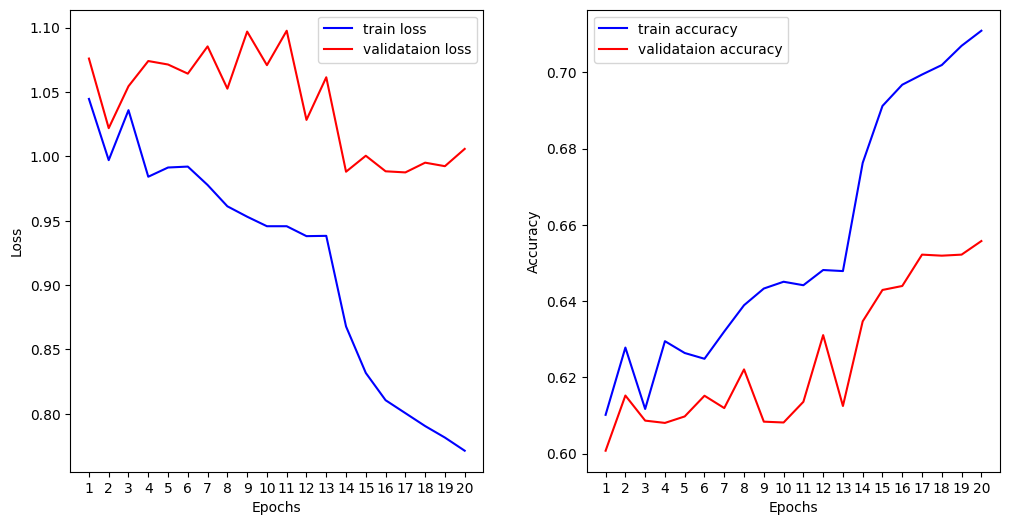

In [184]:
plt.figure(figsize=(12, 6))

# loss plot
plt.subplot(121)
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.xticks(range(EPOCHS), range(1, EPOCHS + 1))
plt.ylabel('Loss')
plt.legend()


# accuracy plot
plt.subplot(122)
plt.plot(train_acc, color='blue', label='train accuracy')
plt.plot(val_acc, color='red', label='validataion accuracy')
plt.xlabel('Epochs')
plt.xticks(range(EPOCHS), range(1, EPOCHS + 1))
plt.ylabel('Accuracy')
plt.legend()
plt.subplots_adjust(wspace=0.25)
plt.show()

# Define Test Function

In [185]:
classes = list(emotion_labels.values())
def test(model, dataloader):
    model.eval()

    # prepare to count predictions for each class
    correct_pred = defaultdict(int)
    total_pred = defaultdict(int)

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing...", total=len(dataloader)):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            all_labels.extend(labels)
            all_predictions.extend(predictions)

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    return correct_pred, total_pred, all_labels, all_predictions

correct_pred, total_pred, all_labels, all_predictions = test(model, test_dataloader)

Testing...:   0%|          | 0/57 [00:00<?, ?it/s]

<ipython-input-170-492a39c40806>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


# Test Accuracy for Each Class

In [186]:
for classname, correct_count in correct_pred.items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.4f}')

total_acc = sum(correct_pred[class_name] for class_name in classes) / len(test_dataset)
print(f"Total test accuracy: {total_acc:.4f}")

Accuracy for class: Angry is 0.5804
Accuracy for class: Sad   is 0.5337
Accuracy for class: Happy is 0.8885
Accuracy for class: Surprise is 0.7716
Accuracy for class: Neutral is 0.7125
Accuracy for class: Fear  is 0.4091
Accuracy for class: Disgust is 0.5636
Total test accuracy: 0.6679


# Confusion Matrix

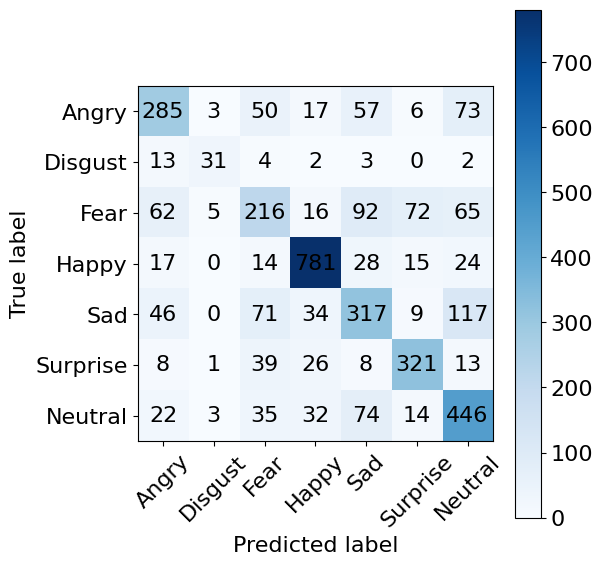

In [189]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix)
    for i in range(0, len(classes)):
        for j in range(0, len(classes)):
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(classes))
    ax.set_xticks(ticks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(all_labels, all_predictions)
plt.show()